In [1]:
import pandas as pd 
import lightgbm as lgb 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import numpy as np

In [2]:
movies = pd.read_csv("/home/rafael/Projetos/classifier_synopsis/data/wiki_movie_plots_deduped_with_summaries.csv")

In [3]:
movies.head(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,PlotSummary
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",Carrie Nation and her followers burst into a s...
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...","The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...","The film, just over a minute long, is composed..."


In [3]:
movies = movies[movies["Genre"] != 'unknown']

In [4]:
pd.DataFrame(movies["Genre"].unique())

,0
0,western
1,comedy
2,short
3,short action/crime western
4,short film
...,...
2259,sport film
2260,"animation, produced by glukoza production"
2261,"adventure, romance, fantasy film"
2262,ero


In [5]:
movies['Genre'].value_counts()

Genre
drama                                                 5964
comedy                                                4379
horror                                                1167
action                                                1098
thriller                                               966
                                                      ... 
action / historical                                      1
fantasy, drama, children's, sci-fi, adventure, spy       1
drama, action, military, spy                             1
drama, kaiju, mecha, space opera, sci-fi, action         1
historical, drama, comedy-drama, romance, youth          1
Name: count, Length: 2264, dtype: int64

In [6]:
top_genres = movies['Genre'].value_counts().head(10).index
top_genres

Index(['drama', 'comedy', 'horror', 'action', 'thriller', 'romance', 'western',
       'crime', 'adventure', 'musical'],
      dtype='object', name='Genre')

In [7]:
movies = movies[movies['Genre'].isin(top_genres)]

In [8]:
movies["Genre"].unique()

array(['western', 'comedy', 'drama', 'adventure', 'horror', 'crime',
       'romance', 'thriller', 'musical', 'action'], dtype=object)

In [9]:
movies.isna().any()

Release Year        False
Title               False
Origin/Ethnicity    False
Director            False
Cast                 True
Genre               False
Wiki Page           False
Plot                False
PlotSummary         False
dtype: bool

In [10]:
movies["PlotSummary"] = movies["PlotSummary"].str.lower().str.replace(r'[^a-z\s]','',regex=True)

In [11]:
movies["PlotSummary"]

6        the film opens with two bandits breaking into ...
7        the film is about a family who move to the sub...
14       mr brown drinks several highball cocktails bef...
15       the plot is that of a black woman going to the...
16       a father and mother take their daughter dollie...
                               ...                        
34874    hasan is a twelveyearold boy living in a mount...
34875    a small group of men search for a buried body ...
34876    the film opens with a senegalese boy named kha...
34882    two musicians salih and grkan described the ad...
34883    zafer a sailor living with his mother dnd in a...
Name: PlotSummary, Length: 16923, dtype: object

In [12]:
le = LabelEncoder()
movies['label'] = le.fit_transform(movies['Genre'])

In [13]:
movies['label'].unique()

array([9, 2, 4, 1, 5, 3, 7, 8, 6, 0])

In [15]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,3))
X = tfidf.fit_transform(movies['PlotSummary'])
y = movies["label"]

In [16]:
X 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1412890 stored elements and shape (20132, 20000)>

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [18]:
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 60,
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271786
[LightGBM] [Info] Number of data points in the train set: 16105, number of used features: 10342
[LightGBM] [Info] Start training from score -2.909238
[LightGBM] [Info] Start training from score -3.644252
[LightGBM] [Info] Start training from score -4.335027
[LightGBM] [Info] Start training from score -1.525510
[LightGBM] [Info] Start training from score -4.445138
[LightGBM] [Info] Start training from score -3.568788
[LightGBM] [Info] Start training from score -3.770683
[LightGBM] [Info] Start training from score -1.216574
[LightGBM] [Info] Start training from score -4.527830
[LightGBM] [Info] Start training from score -4.066484
[LightGBM] [Info] Start training from score -2.847409
[LightGBM] [Info] Start training from score -3.762629
[LightGBM] [Info] Start training from score -4.173456
[Lig

In [19]:
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

                 precision    recall  f1-score   support

         action       0.43      0.20      0.28       220
      adventure       0.33      0.09      0.14       105
      animation       0.91      0.19      0.31        53
         comedy       0.40      0.52      0.45       876
  comedy, drama       0.00      0.00      0.00        47
          crime       0.21      0.04      0.06       114
    crime drama       0.18      0.02      0.04        93
          drama       0.41      0.75      0.53      1193
         family       0.00      0.00      0.00        43
      film noir       0.00      0.00      0.00        69
         horror       0.54      0.35      0.42       233
        musical       0.57      0.09      0.15        93
        mystery       0.45      0.08      0.14        62
        romance       0.43      0.12      0.19       185
romantic comedy       0.00      0.00      0.00        92
         sci-fi       0.17      0.02      0.04        44
science fiction       0.50    

In [21]:
from sklearn.metrics import f1_score
import optuna

study = optuna.create_study(direction="maximize")

def objective(trial):


    learning_rate = trial.suggest_float("learning_rate", 0.015, 0.06)
    num_leaves = trial.suggest_int("num_leaves", 10, 80)
    max_depth = trial.suggest_int("max_depth", 5, 40)
    min_child_samples = trial.suggest_int("min_child_samples", 20, 90)
    subsample = trial.suggest_float("subsample", 0.75, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.55, 0.95)
    n_estimators = trial.suggest_int("n_estimators", 250, 600)
    vectorizer_range = trial.suggest_int("ngram_range", 2, 4)
    max_features = trial.suggest_int("max_features", 1500, 6000)

    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1,vectorizer_range))

    X = tfidf.fit_transform(movies['PlotSummary'])
    y = movies["label"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    
    model = lgb.LGBMClassifier(
    learning_rate=learning_rate,
    num_leaves=num_leaves,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    n_estimators=n_estimators,
    objective='multiclass',
    num_class = len(np.unique(y_train)),
    verbosity = -1,
    random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred, average="macro")

[I 2025-11-21 14:26:26,740] A new study created in memory with name: no-name-7d67237e-702c-40f1-8417-548458ad7e01


In [22]:
study.optimize(objective, n_trials=10)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

/home/rafael/mestrado/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-21 14:27:30,425] Trial 0 finished with value: 0.31417362913607 and parameters: {'learning_rate': 0.032455999936126315, 'num_leaves': 32, 'max_depth': 23, 'min_child_samples': 64, 'subsample': 0.9559418888293671, 'colsample_bytree': 0.9411843333180892, 'n_estimators': 509, 'ngram_range': 3, 'max_features': 3508}. Best is trial 0 with value: 0.31417362913607.
/home/rafael/mestrado/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-21 14:27:54,534] Trial 1 finished with value: 0.3241935291601986 and parameters: {'learning_rate': 0.03339916658723639, 'num_leaves': 38, 'max_depth': 6, 'min_child_samples': 58, 'subsample': 0.7906405121434574, 'col

Best trial:
 Value: 0.3241935291601986
 Params: {'learning_rate': 0.03339916658723639, 'num_leaves': 38, 'max_depth': 6, 'min_child_samples': 58, 'subsample': 0.7906405121434574, 'colsample_bytree': 0.6364790848004938, 'n_estimators': 441, 'ngram_range': 2, 'max_features': 2476}


In [15]:
from sentence_transformers import SentenceTransformer

X = movies['PlotSummary'].to_numpy()
y = movies["label"]

model = SentenceTransformer("all-mpnet-base-v2")
X_emb = model.encode(X, convert_to_numpy=True)

In [16]:
X_emb

array([[-0.02561502,  0.04492914,  0.03317907, ...,  0.02910945,
        -0.01173855,  0.01885513],
       [ 0.0132623 , -0.02838262,  0.01314141, ...,  0.0076805 ,
        -0.03386214, -0.00259956],
       [ 0.01149078, -0.01972114, -0.01036405, ...,  0.00256524,
         0.05521334, -0.03754546],
       ...,
       [ 0.03897572, -0.03257013, -0.01494966, ...,  0.00147444,
         0.02580352, -0.00995258],
       [ 0.02382437, -0.03863153, -0.01434946, ...,  0.04618609,
         0.01399304, -0.04970302],
       [ 0.02302775, -0.0415324 , -0.01757008, ...,  0.04135225,
         0.01718005, -0.02149665]], shape=(16923, 768), dtype=float32)

(array([[  0.,   0.,   0., ..., 188.,   2.,   0.],
        [  0.,   0.,   6., ..., 825.,  46.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ..., 107.,   0.,   0.],
        [  0.,   0.,   1., ..., 103.,   0.,   0.],
        [  0.,   0.,   1., ...,   1.,   0.,   0.]], shape=(768, 10)),
 array([-0.24441928, -0.19803756, -0.15165587, -0.10527417, -0.05889246,
        -0.01251075,  0.03387094,  0.08025265,  0.12663436,  0.17301607,
         0.21939777]),
 <a list of 768 BarContainer objects>)

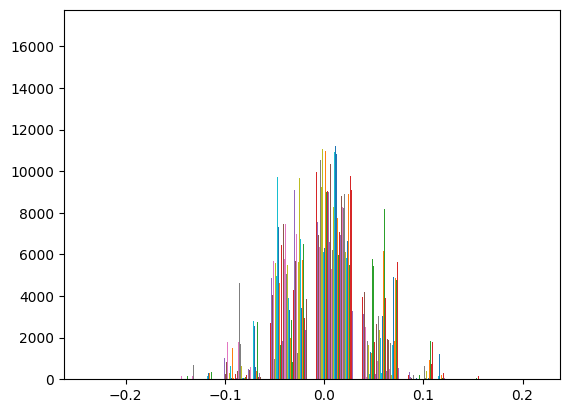

In [17]:
import matplotlib.pyplot as plt 
plt.hist(X_emb)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_emb, y, stratify=y, test_size=0.2, random_state=42)

In [22]:
from sklearn.metrics import f1_score
import optuna

study = optuna.create_study(direction="maximize")

def objective(trial):


    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    num_leaves = trial.suggest_int("num_leaves", 5, 200)
    max_depth = trial.suggest_int("max_depth", 5, 200)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 200)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 0.95)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)

    model = lgb.LGBMClassifier(
    learning_rate=learning_rate,
    num_leaves=num_leaves,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    n_estimators=n_estimators,
    objective='multiclass',
    num_class = len(np.unique(y_train)),
    verbosity = -1,
    random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred, average="macro")

[I 2025-11-21 15:45:30,838] A new study created in memory with name: no-name-90b4a46c-2802-4c19-a4ec-df6bc4c8fd8b


In [23]:
study.optimize(objective, n_trials=10)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

/home/rafael/mestrado/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-21 15:45:43,375] Trial 0 finished with value: 0.40249107694414554 and parameters: {'learning_rate': 0.07156088907864741, 'num_leaves': 79, 'max_depth': 63, 'min_child_samples': 165, 'subsample': 0.5269740842861151, 'colsample_bytree': 0.1432906423241895, 'n_estimators': 95}. Best is trial 0 with value: 0.40249107694414554.
/home/rafael/mestrado/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-21 15:45:58,529] Trial 1 finished with value: 0.4197148782337473 and parameters: {'learning_rate': 0.011104745559941842, 'num_leaves': 22, 'max_depth': 196, 'min_child_samples': 168, 'subsample': 0.6338972569193673, 'colsample_bytree': 0.1558299880786

Best trial:
 Value: 0.4197148782337473
 Params: {'learning_rate': 0.011104745559941842, 'num_leaves': 22, 'max_depth': 196, 'min_child_samples': 168, 'subsample': 0.6338972569193673, 'colsample_bytree': 0.1558299880786462, 'n_estimators': 430}


In [24]:
study.best_trial.params

{'learning_rate': 0.011104745559941842,
 'num_leaves': 22,
 'max_depth': 196,
 'min_child_samples': 168,
 'subsample': 0.6338972569193673,
 'colsample_bytree': 0.1558299880786462,
 'n_estimators': 430}

In [26]:
model = lgb.LGBMClassifier(
    learning_rate=study.best_trial.params["learning_rate"],
    num_leaves=study.best_trial.params["num_leaves"],
    max_depth=study.best_trial.params["max_depth"],
    min_child_samples=study.best_trial.params["min_child_samples"],
    subsample=study.best_trial.params["subsample"],
    colsample_bytree=study.best_trial.params["colsample_bytree"],
    n_estimators=study.best_trial.params["n_estimators"],
    objective='multiclass',
    num_class = len(np.unique(y_train)),
    verbosity = -1,
    random_state=42)

model.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,22
,max_depth,196
,learning_rate,0.011104745559941842
,n_estimators,430
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,168


In [27]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      action       0.48      0.36      0.41       220
   adventure       0.58      0.20      0.30       105
      comedy       0.56      0.56      0.56       876
       crime       0.33      0.15      0.21       114
       drama       0.51      0.75      0.61      1193
      horror       0.69      0.58      0.63       233
     musical       0.67      0.15      0.25        93
     romance       0.46      0.26      0.33       185
    thriller       0.44      0.11      0.17       193
     western       0.79      0.68      0.73       173

    accuracy                           0.54      3385
   macro avg       0.55      0.38      0.42      3385
weighted avg       0.54      0.54      0.52      3385



/home/rafael/mestrado/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
